In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms

In [3]:
# download mnist data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)


In [3]:
# small network for mnist
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 3) # 28x28x1 -> 26x26x10
        self.maxpool1 = nn.MaxPool2d(2) # 26x26x10 -> 13x13x10
        self.conv2 = nn.Conv2d(10, 20, 3) # 13x13x10 -> 11x11x20
        self.fc1 = nn.Linear(11*11*20, 50) # 11x11x20 -> 50
        self.fc2 = nn.Linear(50, 10) # 50 -> 10

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, 11*11*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create model
model = Net().to(device)

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# train model
epochs = 20
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward pass
        output = model(images)

        # calculate loss
        loss = F.cross_entropy(output, labels)

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()

        running_loss += loss.item()

    print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 0.09563034072693095
Training loss: 0.08807557774509099
Training loss: 0.08239729770385762
Training loss: 0.07690306815719887
Training loss: 0.07237183576328621
Training loss: 0.06855100507575915
Training loss: 0.06461326471730464
Training loss: 0.06107026164872703
Training loss: 0.05730739029284233
Training loss: 0.05508307570905319


In [11]:
# test model
test_loss = 0
accuracy = 0
with torch.no_grad():
    for images, labels in test_loader:
        # move tensors to device
        images, labels = images.to(device), labels.to(device)

        # forward pass
        output = model(images)

        # calculate loss
        test_loss += F.cross_entropy(output, labels).item()

        # calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f"Test loss: {test_loss/len(test_loader)}")
print(f"Test accuracy: {accuracy/len(test_loader)}")

Test loss: 0.06412014794524071
Test accuracy: 0.9791003465652466


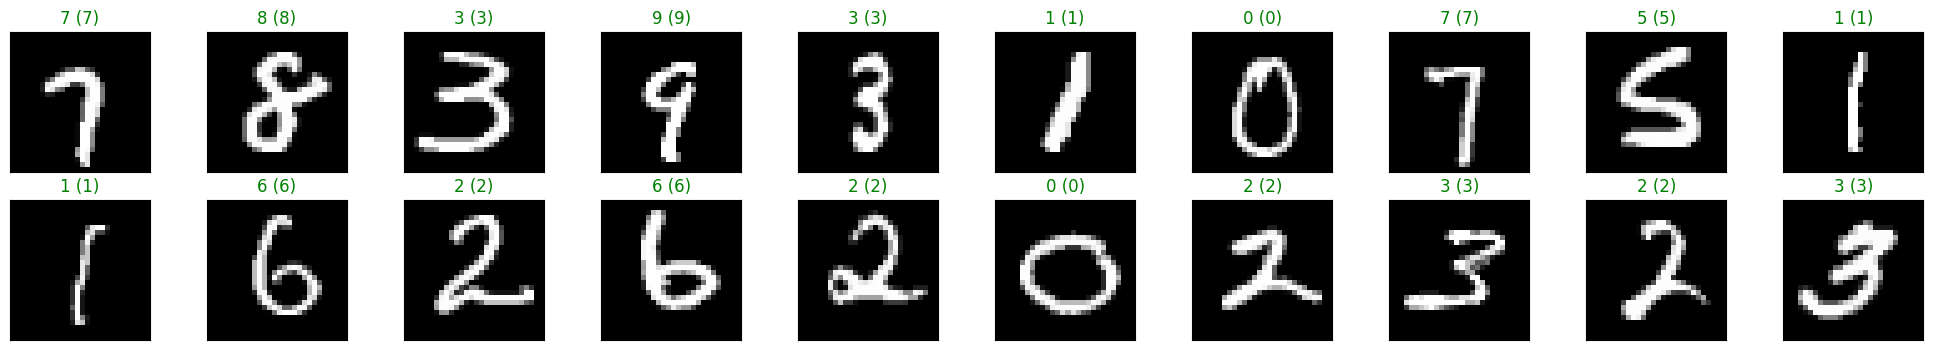

In [12]:
# show some examples
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"{preds[idx]} ({labels[idx]})",
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [13]:
# export model to onnx
torch.onnx.export(
    model,
    torch.from_numpy(images).to(device),
    "mnist.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)


Exported graph: graph(%input : Float(*, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %conv1.weight : Float(10, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv1.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0),
      %conv2.weight : Float(20, 10, 3, 3, strides=[90, 9, 3, 1], requires_grad=1, device=cuda:0),
      %conv2.bias : Float(20, strides=[1], requires_grad=1, device=cuda:0),
      %fc1.weight : Float(50, 2420, strides=[2420, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(50, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(10, 50, strides=[50, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %/conv1/Conv_output_0 : Float(*, 10, 26, 26, strides=[6760, 676, 26, 1], requires_grad=0, device=cuda:0) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/conv1/C

In [16]:
# save an example of each image to a folder ./mnist_digits
import matplotlib.pyplot as plt

# create folder:
import os
if not os.path.exists("./mnist_digits"):
    os.makedirs("./mnist_digits")

mnist_digit: list[torch.Tensor] = []
for i in range(10):
    mnist_digit.append(train_data.data[train_data.targets == i][0])

# show all an example of each mnist digit:
for i in range(10):
    plt.imsave(f"./mnist_digits/{i}.png", mnist_digit[i], cmap="gray")
    